In [1]:
%run Preamble.py

# Monte Carlo Simulation Variance Reduction Method -- Control Variates
### Thomas Polstra, PhD

##### [GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)

### Control Variants in Modeling

Control variants enhance simulation accuracy by introducing auxiliary variables with known relationships to the primary variable of interest. This technique reduces variance and improves precision, particularly in complex simulations where accurate modeling is challenging. Control variants are widely used across disciplines to refine simulations and yield more accurate results.

Control variants are a valuable strategy in Monte Carlo simulations for option pricing. In this context, control variants involve incorporating auxiliary variables that are correlated with the option's underlying asset. The objective of valuing an option price is often achieved when the option price estimate $C$ is adjusted using an additional term with an expected value of $0$. This supplementary term is carefully selected to be negatively correlated with the value of $C$ relative to the underlying asset's price. By incorporating this negatively correlated component, the variance of the simulation is effectively reduced, leading to more accurate option price estimates. 

Both static and dynamic hedging strategies in option trading provide control variates in Monte-Carlo simulations of option pricing. In both cases, the difference between the changes in the portfolio's value and the changes in the option price acts as a control variate. This difference is essentially a byproduct of the hedging strategy. By incorporating this control variate into the option price estimation process, the variance of the simulation is reduced, leading to more accurate pricing results. In essence, both static and dynamic hedging strategies serve as tools that provide a means to minimize uncertainties and refine option price estimations in the context of Monte Carlo simulations.

**Control Variant Example: Stradle Option Strategy**
Before we show how delta hedging brings to light natural control variants for pricing an option, we first demonstrate the usefullness of control variants by modeling the value of a straddle option strategy, i.e. buy a call and put on a common asset.

A put and a call on on a common asset are negatively correlated. We will perform Monte-Carlo simulations on a put and call seperately and then model the stradle strategy by summing the two options. Our simulations for the sum of the two models will have significantly less variance than either the call or put price modeling.

In [2]:
#Monte Carlo simulation of a straddle option strategy
S = 100
K1 = 110
K2=100
T = 75/252
steps = 2
N = 1000
sigma = .3
A = geo_paths(S,T,sigma,steps,S,N)
call_price = bs('c',S,K1,T,0,sigma)
put_price = bs('p',S,K2,T,0,sigma)

call_prices = np.maximum(A[-1]-K1,0)

put_prices = np.maximum(-A[-1]+K2,0)

call_put_prices = .5*(call_prices + put_prices)

SE_call = standard_error(call_prices,T)
SE_put = standard_error(put_prices,T)
SE_call_put = standard_error(call_put_prices,T) 
#Multiplication by .5 is to represent that we will own the same number as contracts in this position as in just owning calls or puts.

print('Monte-Carlo simulated prices:')
print('----------')
print(f'Monte-Carlo simulated Call value: {np.mean(call_prices)}')

print(f'Monte-Carlo Put Value: {np.mean(put_prices)}')

print(f'Value of call plus put option: {np.mean(0.5*call_prices + 0.5*put_prices)}')

print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')

print('Comparison of standard errors/model variance:')
print('----------')
print(f'Standard error of call option value: {SE_call}')
print(f'Standard error of put option value: {SE_put}')
print(f'Standard error of call plus put option: {SE_call_put}')


print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('Black-Scholes pricing vs Monte-Carlo pricing:')

print('----------')
print(f"Call value Black-Scholes: {bs('c',S,K1,T,0,sigma)} vs Call value Monte-Carlo: {np.mean(call_prices)}")
print(f"Put value Black-Scholes: {bs('p',S,K2,T,0,sigma)} vs Call value Monte-Carlo: {np.mean(put_prices)}")
print(f"Straddle value Black-Scholes: {.5*bs('c',S,K1,T,0,sigma)+.5*bs('p',S,K2,T,0,sigma)} vs Call value Monte-Carlo: {np.mean(0.5*call_prices + 0.5*put_prices)}")

Monte-Carlo simulated prices:
----------
Monte-Carlo simulated Call value: 2.9566753810786124
Monte-Carlo Put Value: 5.855407958249793
Value of call plus put option: 4.406041669664202
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
Comparison of standard errors/model variance:
----------
Standard error of call option value: 0.22754075852450228
Standard error of put option value: 0.2630698663321335
Standard error of call plus put option: 0.14690201709677186
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
--------------------------------------

### Visualizing Monte-Carlo simulations and model variance

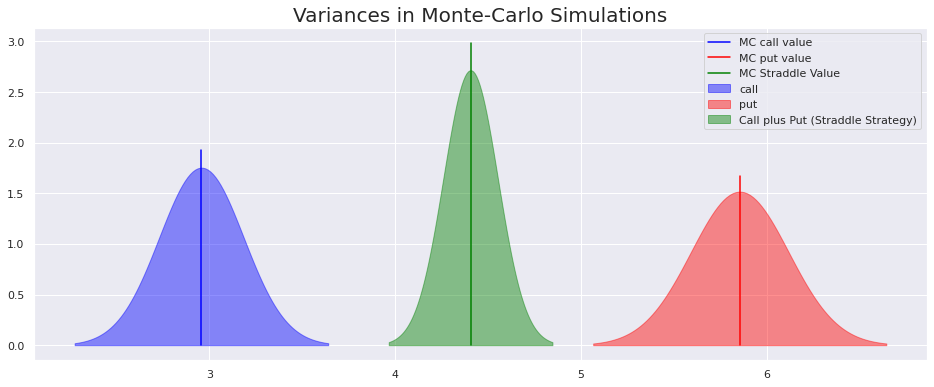

In [3]:
call_MC = np.mean(call_prices)
put_MC = np.mean(put_prices)
call_put_MC = (call_MC+put_MC)/2
x1 = np.linspace(call_MC-3*SE_call,call_MC+3*SE_call,num=100)
x2 = np.linspace(put_MC-3*SE_put,put_MC+3*SE_put,num=100)
x3 = np.linspace(call_put_MC-3*SE_call_put,call_put_MC+3*SE_call_put,num=100)
s1 = stats.norm.pdf(x1, call_MC, SE_call)
s2 = stats.norm.pdf(x2, put_MC, SE_put)
s3 = stats.norm.pdf(x3, call_put_MC, SE_call_put)



plt.fill_between(x1,s1,color='blue', alpha = .44,label = 'call')
plt.fill_between(x2,s2,color='red', alpha = .44,label='put')
plt.fill_between(x3,s3,color='green', alpha = .44,label='Call plus Put (Straddle Strategy)')


bs_call = bs('c',S,K1,T,0,sigma)
bs_put = bs('p',S,K2,T,0,sigma)
bs_call_put = np.mean([bs_call,bs_put])

plt.plot([call_MC,call_MC],[0, max(s1)*1.1], 
        label='MC call value', color = 'blue')
plt.plot([put_MC,put_MC],[0, max(s2)*1.1], 
        label='MC put value', color = 'red')
plt.plot([call_put_MC,call_put_MC],[0, max(s3)*1.1], 
        label='MC Straddle Value', color = 'green')




plt.title('Variances in Monte-Carlo Simulations',size = 20)
plt.legend()
plt.show()

## Improving Option Pricing through a static hedge

Consider a put on a stock whose strike price is the current asset price of the underlying stock. The rate of change of the value of the put $P$, relative to price of the under asset $S$, at the initial contract date is $-.5$, i.e. the rate of change of the initial value of the put is $-.5$ times the rate of change of the price of the underlying stock.

We are assuming that stock movements are Geometric Brownian Movements. In particular, the expected value of a stock at time $t$ is the value of the stock at anytime prior to $t$. We conclude the following:

1) The expected value of S_t-S_0 is 0.
2) P_{t_0} is negatively correlated with .5*(S_t-S_0).

We can simulate the fair market price $P_0$ of the option, with less variance, by simulating $P_0$ as usual and then adjusting each simulated value by adding $.5*(S_t-S_0)$ and the results will have significantly less variance.

In [4]:
S = 100
K=100
T = 75/252
steps = 2
N = 10000
sigma = .3
A = geo_paths(S,T,sigma,steps,S,N)
put_prices = np.maximum(-A[-1]+K2,0)
put_prices_st_hedge = put_prices + 0.5*(A[-1]-S)

SE_put = standard_error(put_prices,T) 
SE_put__st_hedge = standard_error(put_prices_st_hedge,T) 

print(f'Monte-Carlo Put Value: {np.mean(put_prices)}')
print('-----------')
print(f'Monte-Carlo Put with Hedge Value: {np.mean(put_prices_st_hedge)}')
print('----------')
print(f"Put value Black-Scholes: {bs('p',S,K2,T,0,sigma)}")

print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')


print('Comparison of standard errors/model variance:')
print('----------')
print(f'Standard error of put option Monte Carlo Simulation: {SE_put}')
print(f'Standard error of put plus hedge Monte Carlo Simulation: {SE_put__st_hedge}')

print('------------')

Monte-Carlo Put Value: 6.420301412063676
-----------
Monte-Carlo Put with Hedge Value: 6.429053888881645
----------
Put value Black-Scholes: 6.521945938155881
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
Comparison of standard errors/model variance:
----------
Standard error of put option Monte Carlo Simulation: 0.0853443370922868
Standard error of put plus hedge Monte Carlo Simulation: 0.04998920772727258
------------


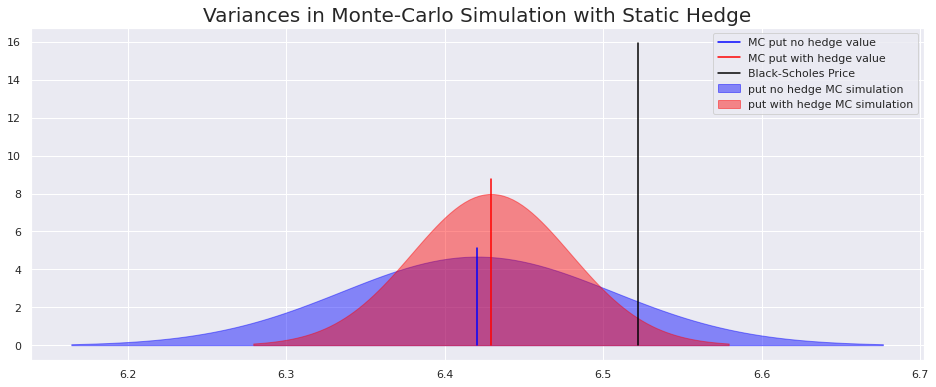

In [5]:
#Visual comparison
put_MC = np.mean(put_prices)
put_st_hedge_MC = np.mean(put_prices_st_hedge)
SE1 = standard_error(put_prices,T)
SE2 = standard_error(put_prices_st_hedge,T)

x1 = np.linspace(put_MC-3*SE1,put_MC+3*SE1,num=100)
x2 = np.linspace(put_st_hedge_MC-3*SE2, put_st_hedge_MC+3*SE2,num=100)

s1 = stats.norm.pdf(x1, put_MC, SE1)
s2 = stats.norm.pdf(x2, put_st_hedge_MC, SE2)




plt.fill_between(x1,s1,color='blue', alpha = .44,label = 'put no hedge MC simulation')
plt.fill_between(x2,s2,color='red', alpha = .44,label='put with hedge MC simulation')



bs_put = bs('p',S,K,T,0,sigma)


plt.plot([put_MC,put_MC],[0, max(s1)*1.1], 
        label='MC put no hedge value', color = 'blue')
plt.plot([put_st_hedge_MC,put_st_hedge_MC],[0, max(s2)*1.1], 
        label='MC put with hedge value', color = 'red')

plt.plot([bs_put,bs_put],[0, max(s2)*2], 
        label='Black-Scholes Price', color = 'black')



plt.title('Variances in Monte-Carlo Simulation with Static Hedge',size = 20)
plt.legend()
plt.show()

## Improving Option Pricing through dynamic hedging
Now let's recall the process of dynamically hedging an European option to introduce powerful control variants in Monte-Carlo simulations of option pricing.

**Dynamic Hedging of a Put/Call option through buying/shorting stock**
Let $C_t$ be the value of a an option at time $t$ on an underlying stock $S$. Let's consider the process of dynamically hedging the option over the time intervals seperated by times $t_0,t_1,\ldots,t_N$ with $t_0$ the contracts initiation date and $t_N$ the termination date. For each $i$ let $\Delta_{t_i} = \frac{\partial C_{t_i}}{\partial S}$. Recall that buying $x>0$ shares of a stock has a constant delta value of $x$ and shorting $x>0$ shares of the underlying has a constant delta value of $-x$. We will let $P_t$ be the value of the hedged position at time $t$.

0) At time $t_0$ we hedge (i.e. neutralize the current delta of the option's value to the underlying's movement) by buying, respectively shorting, $|\Delta_{t_0}|$ shares of stock if $\Delta_{t_0}$ is negative, respectively positive. The value of the first hedge at a time $t$ is $-\Delta_{t_0}(S_{t}-S_{t_0})(t-t_0)$.

**Key Point**: $-\Delta_{t_0}(S_{t}-S_{t_0})$ is negatively correlated with $C_t$ (and perfectly so at time $t_0$ by design). If we assume the stocks price $S_t$ is a Geometric Brownian Motion then the expected value of $S_t$ under a Monte-Carlo simulation of stock movement starting at time $t_0$ is $S_{t_0}$. Therefore, in addition to being negatively correlated to $C_t$, $-\Delta_{t_0}(S_{t}-S_{t_0})$ has an expected value of $0$. Therefore performing a Monte-Marlo simulation of the stocks movement and summing the simulated values of $C_t$ and $-\Delta_{t_0}(S_{t}-S_{t_0})$ will produce estimates of $C_t$ with less variance than the simulated prices of $C_t$ without the hedge.

Let's consider the hedging process at time $t_1$.
1) If $t_0\leq t<t_1$ then $$P_t = C_t-\Delta_{t_0}(S_{t}-S_{t_0}).$$ Taking taking a derivative with respect to $S$, $$\frac{\partial P_t}{\partial S}=\Delta_{t}-\Delta_{t_0}.$$ Therefore to neutralize the rate of change of the value of our position relative to the price of the underlying $S_t$ at time $t_1$ we buy, repectively short, $|\Delta_{t_1}-\Delta_{t_0}|$ shares of the stock if $\Delta_{t_1}-\Delta_{t_0} <0$, respectively $\Delta_{t_1}-\Delta_{t_0} > 0$. The value of this hedge at times $t \geq t_1$ is $-(\Delta_{t_1}-\Delta_{t_0})(S_t-S_{t_1})$. The value of the twice hedged position at time $t$ is then 

$$P_t = C_t-\Delta_{t_0}(S_t-S_{t_0})-(\Delta_{t_1}-\Delta_{t_0})(S_t-S_{t_1}).$$
A little bit of algebra magic reveals:
$$P_t = C_t-(\Delta_{t_1}(S_{t}-S_{t_1})+\Delta_{t_0}(S_{t_1}-S_{t_0}))$$

**Key Point**: Let us suppose that we dynamically hedged over two time intervals and set $t=t_2$ in the above equation. Then $\Delta_{t_1}(S_{t_2}-S_{t_1})$ in the hedge component of the position, is negatively correlated with the values of $P_t$ over the interval $[t_1,t_2]$ and subtracting it serves to cancel out variation of the option pricing through this part of the time interval. Similarly, the second hedging term $\Delta_{t_0}(S_{t_1}-S_{t_0})$ serves to cancel out variation in the option price simuation over the interval $[t_0,t_1]$.



2) If we continue this process, then the value of our position at the termination of the contract is is $$P_{t_N} = C_{t_N} -\sum_{i=0}^{N}(\Delta_{t_i}-\Delta_{t_{i-1}})(S_{t_N}-S_{t_i}) =^{\text{Algebra}} C_{t_N}-\sum_{i=0}^{N-1}\Delta_{t_i}(S_{t_{i+1}}-S_{t_i}).$$ 


**Key Point** The term $\Delta_{t_i}(S_{t_{i+1}}-S_{t_i})$ in the hedging component will remove variance in the simulated prices of the option over the partial time interval $[t_i, t_{i+1}]$.

**WARNING!!!** One who understands the mathematical material, but maybe not so much computational errors in computers, may be tempted to use the equivalent formulation of the hedged option value as  $$P_{t_N} = C_{t_N} -\sum_{i=0}^{n}(\Delta_{t_i}-\Delta_{t_{i-1}})(S_{t_N}-S_{t_i})$$ and use Monte-Carlo simulations of the underlying to model $C_{t_N}$ and the individual hedging components $(\Delta_{t_i}-\Delta_{t_{i-1}})(S_{t_N}-S_{t_i})$. Theoretically, this works. Indeed, the term $-(\Delta_{\ell}-\Delta_{\ell-1})(S_{t}-S_\ell)$ is negatively correlated with the partial hedged value $ C_{t_N} -\sum_{i=0}^{\ell-1}(\Delta_{i}-\Delta_{i-1})(S_{t_N}-S_i)$, and perfectly so at time $t_\ell$ by design. Therefore a Monte Carlo simulation of the partial sum is negatively correlated with $(\Delta_{\ell}-\Delta_{\ell-1})(S_{t_N}-S_\ell)$, whose expected value is $0$, and adding this term to the simulation will theoretically improve the accuracy of the option pricing by further reducing variance in the simulated prices. However, issues arise as many of the values may be too small in this approach and rounding errors at various stages of the simulation will amass to large errors in the simulation, something we will verify by example.

The following example runs a Monte-Carlo simulation of a stocks movement and the value of put is modeled in three ways for comparison. We will model it without hedging components, model with the hedging component discussed prior to the warning above, and we will model with the theoretically equivalent hedging approach discussed in the warning. The first hedging approach to variance reduction will be quite successeful in modeling the option price compared to the non-hedged valuation, whereas the second hedging approach will not have as accurate of approximations.

In [9]:
K = 100  # Strike price
DTE = 50  # Trading Days
N = int(DTE/5)  # Number of time hedging time intervals
sigma = 0.30  # Volatility
S0 = 100  # Initial stock price
T = DTE / 252  # Time to expiration in years
r = 0  # Risk-free rate
M = 10000 # Number of Simulations

DT = T / N  # Time interval between steps
TTE = [T - DT * i for i in range(0, N + 1)]  # Time to expiration at each step

# Simulate asset price paths as GBMs
A = geo_paths(S0,TTE[0],sigma,N,K,M)

Deltas = np.zeros((N+1,M)) #Store the Deltas of the put contract at each time step for each simulation
Deltas[0] = [delta('p',S0,K,T,r,sigma)]

# Vectorized loop to store the deltas of the option contract at each time step for each simulation
for i in range(1, N):
    time_to_expire = TTE[i]
    Deltas[i] = [delta('p',A[i][j],K,time_to_expire,r,sigma) for j in range(M)]


#Vectorized caluculation of accurate hedged corrections
X = np.array([-np.array(Deltas[i])*np.array((A[i+1]-A[i])) for i in range(N)])
hedge_values = np.sum(X,axis=0)

#Vectorized caluculation of inaccurate hedged corrections
Y = np.array([-np.array(Deltas[i]-Deltas[i-1])*np.array((A[-1]-A[i])) for i in range(1,N+1)])
hedge_values_bad = np.sum(Y,axis=0)

#Slow method for computing hedged values
#for j in range(M):
    #hedge_values[j] = sum(-Deltas[i][j]*(A[i+1][j]-A[i][j]) for i in range(N))
        
put_values = np.maximum(-A[-1]+K,0)
SE1 = standard_error(put_values,T)
hedged_position_values = put_values + hedge_values
SE2 = standard_error(hedged_position_values,T)
hedged_position_values_bad = put_values + hedge_values_bad
SE3 = standard_error(hedged_position_values_bad,T)

print(f'Monte-Carlo Put Value without hedge: {np.mean(put_values)} with standard error {SE1}')
print('-----------')
print(f'Monte-Carlo Put with good hedge adjustment: {np.mean(hedged_position_values)} with standard error {SE2}')
print('----------')
print(f'Monte-Carlo Put with bad hedge adjustment: {np.mean(hedged_position_values_bad)} with standard error {SE3}')
print('--------------')
print(f"Put value Black-Scholes: {bs('p',S0,K,T,0,sigma)}")

print('------------------------------------------------------------')
print('------------------------------------------------------------')
print('------------------------------------------------------------')


Monte-Carlo Put Value without hedge: 5.342812033107935 with standard error 0.07164718533425923
-----------
Monte-Carlo Put with good hedge adjustment: 5.31762878941734 with standard error 0.014169873734824125
----------
Monte-Carlo Put with bad hedge adjustment: 5.372901687939412 with standard error 0.06434659075073888
--------------
Put value Black-Scholes: 5.327126535189609
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


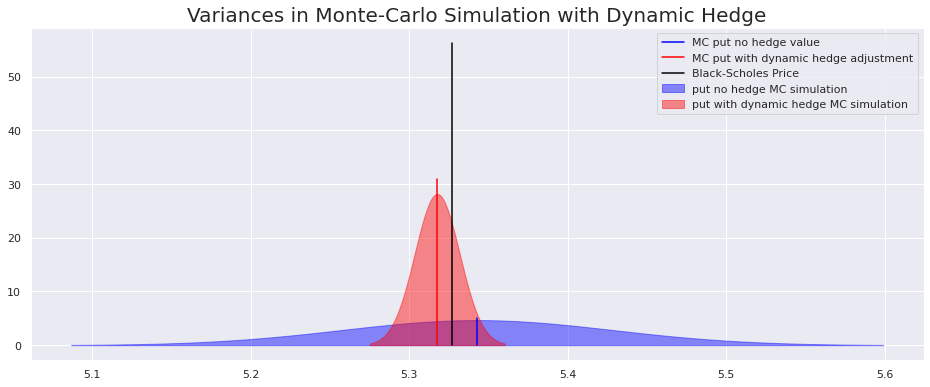

In [10]:
#Visual comparison
put_MC = np.mean(put_values)
put_st_hedge_MC = np.mean(hedged_position_values)
SE1 = standard_error(put_prices,T)
SE2 = standard_error(hedged_position_values,T)

x1 = np.linspace(put_MC-3*SE1,put_MC+3*SE1,num=100)
x2 = np.linspace(put_st_hedge_MC-3*SE2, put_st_hedge_MC+3*SE2,num=100)

s1 = stats.norm.pdf(x1, put_MC, SE1)
s2 = stats.norm.pdf(x2, put_st_hedge_MC, SE2)




plt.fill_between(x1,s1,color='blue', alpha = .44,label = 'put no hedge MC simulation')
plt.fill_between(x2,s2,color='red', alpha = .44,label='put with dynamic hedge MC simulation')



bs_put = bs('p',S,K,T,0,sigma)


plt.plot([put_MC,put_MC],[0, max(s1)*1.1], 
        label='MC put no hedge value', color = 'blue')
plt.plot([put_st_hedge_MC,put_st_hedge_MC],[0, max(s2)*1.1], 
        label='MC put with dynamic hedge adjustment', color = 'red')

plt.plot([bs_put,bs_put],[0, max(s2)*2], 
        label='Black-Scholes Price', color = 'black')



plt.title('Variances in Monte-Carlo Simulation with Dynamic Hedge',size = 20)
plt.legend()
plt.show()